In [ ]:
from google.colab import drive
# drive.mount("/content/gdrive/", force_remount=True)
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
# import os
import keras
import numpy as np
import numpy.random as rng
import random
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Sequential,load_model, Model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers as rg
from tensorflow.keras import callbacks as cb


In [ ]:

lr = 0.001
eps = 1e-12

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

#build convnet to use in each siamese 'leg'
def conv_net(dim):
    convnet = Sequential()
    #convn et.add(tf.keras.layers.RandomFlip( mode=HORIZONTAL_AND_VERTICAL, seed=None, **kwargs))
    for i in range(4):
        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    #convnet.add(Normalization(mean=0., variance=1.))
    return convnet

def make_generator_model(dim):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3),  padding='same', input_shape=dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(augmentLayer())
    #model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64,(5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64,(5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64,(5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(3, (1,1), padding='same',use_bias=False, activation='sigmoid'))

    #model.add(layers.ReLU())
    return model

from keras.backend import dropout
def minMax1(xx):  # Negative softmax distance measure
    M1=tf.reshape(tf.reduce_max(xx, axis=1),(-1,1))+1
    m1=tf.reshape(tf.reduce_min(xx, axis=1),(-1,1))
    return (xx-m1)/(M1-m1)
def minMax(xx):  # Negative softmax distance measure
    M1=tf.reshape(tf.reduce_max(xx)+0.01)
    m1=tf.reshape(tf.reduce_min(xx))
    return (xx-m1)/(M1-m1)

def normalise(xx):
  global noise
  std = tf.reshape(tf.math.reduce_std(xx,axis=1),(-1,1))
  meanFeature = tf.reshape(tf.reduce_mean(xx,axis=1),(-1,1))
  out_feature = (xx- meanFeature)/std
  return out_feature


def proto_dist(x):  # Negative softmax distance measure
    feature, pred = x
    pred_dist = tf.reduce_sum(pred ** 2, axis=1, keepdims=True)
    feature_dist = tf.reduce_sum(feature ** 2, axis=1, keepdims=True)
    #print(pred_dist.shape);  print(feature_dist.shape)
    dot = tf.matmul(pred, tf.transpose(feature))
    #print(dot.shape)
    return tf.nn.softmax(-(tf.sqrt(pred_dist + tf.transpose(feature_dist) - 2 * dot)))

def cosine_distances(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance

def reduce_tensor(x):
    y=tf.reduce_mean(x, axis=1)
    return y

def reshape_query(x):  # reshape query output to  dimention 64*query,1
    y=tf.reshape(x, [-1, tf.shape(x)[-1]])
    return y

def Bias_net(dim):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size =(3,1),padding ='same', activation ='linear', input_shape = dim))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 8, kernel_size =(3,1),padding ='same', activation ='linear'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 1, kernel_size =(3,1), padding ='same', activation='linear'))
    return model


In [ ]:
root_path = 'gdrive/My Drive/MINI PROJECT'
# root_path = 'gdrive/My Drive/phd' #/kksFiles'
print(os.getcwd())
os.chdir(root_path)
!ls

/content
 cifar100.ipynb     mammals			    Model
 images_array.pkl   mini-imagenet-cache-test.pkl    Test.ipynb
 labels_array.pkl   mini-imagenet-cache-train.pkl  'transfer Learning.ipynb'
 logs		    mini-imagenet-cache-val.pkl


#Cifar

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

# Check the shapes
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

# Print x_train shape
print("x_train shape:", x_train.shape)

# Reshape and select a subset of x_train
xCifar = np.reshape(x_train, (-1, 500, 32, 32, 3))[:, 0:20, :, :, :]
print("xCifar shape:", xCifar.shape)

# Flatten y_train to a 1D array for easier sorting
y_train_flat = y_train.flatten()

# Combine x_train and y_train
combined = list(zip(x_train, y_train_flat))

# Sort the combined list by the labels
sorted_combined = sorted(combined, key=lambda x: x[1])

# Separate the sorted data and labels
sorted_data, sorted_labels = zip(*sorted_combined)

# Convert sorted_data and sorted_labels back to numpy arrays
sorted_data = np.array(sorted_data)
sorted_labels = np.array(sorted_labels).reshape(-1, 1)

# Verify the sorting (Optional)
print("First 10 sorted labels:", sorted_labels[:10].flatten())


169001437/169001437 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)
xCifar shape: (100, 20, 32, 32, 3)
First 10 sorted labels: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(sorted_data.shape)

(50000, 32, 32, 3)


[0]
[0]
[1]
[1]
[2]
[2]
[3]
[3]
[4]
[4]


ValueError: num must be an integer with 1 <= num <= 10, not 11

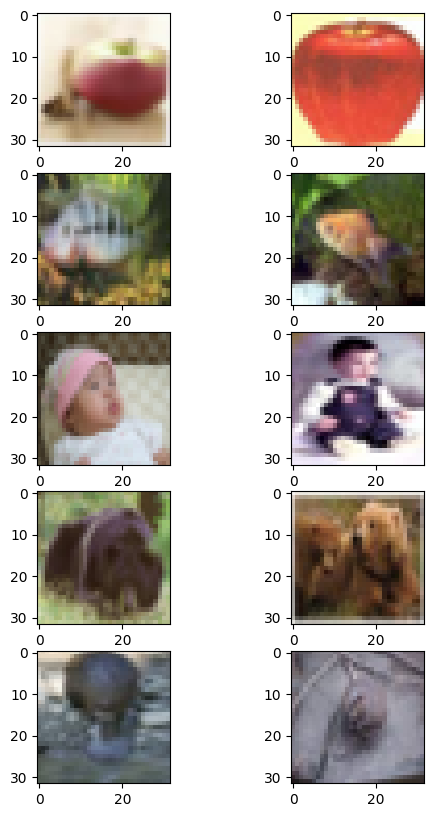

In [ ]:
fig = plt.figure(figsize=(6, 10))
j=1
for i in range(0,4500,500):
  plt.subplot(5,2,j)
  plt.imshow(sorted_data[i])
  print(sorted_labels[i])

  plt.subplot(5,2,j+1)
  plt.imshow(sorted_data[i+499])
  print(sorted_labels[i+499])
  j=j+2
plt.show()

In [ ]:
import cv2
auxData= np.reshape(np.reshape(sorted_data,(-1,500,32,32,3))[:,:20,:,:,:],(-1,32,32,3))
print(auxData.shape)
auxData1 = []

for i in range(0,2000,1):
    auxData1.append(cv2.resize(auxData[i,:,:,:],(84,84)))
auxData1 = np.array(auxData1)
print(auxData1.shape)

(2000, 32, 32, 3)
(2000, 84, 84, 3)


#Module


In [ ]:
  # import pandas as pd
  # df = pd.read_pickle("images_array.pkl")
  # df2 = pd.read_pickle("labels_array.pkl")
  # x_train=np.array(df) #['image_data']);
  # y_train = df2
  # #x_train = np.reshape(np.mean(x_train,axis=3),(-1,84,84,1)).astype('float32')
  # x_train = np.reshape(x_train,(-1,84,84,3)).astype('float32')
  # # print(x_train.shape)
  # x_train /=255 #(x_train1-127)/127
  # print(x_train.shape)

(10000, 84, 84, 3)


In [ ]:
# fig = plt.figure(figsize=(6, 10))
# j=1
# for i in range(0,100,20):
#   plt.subplot(5,2,j)
#   plt.imshow(x_train[i])
#   print(y_train[i])

#   plt.subplot(5,2,j+1)
#   plt.imshow(x_train[i+19])
#   print(y_train[i+19])
#   j=j+2
# plt.show()

In [ ]:
model= load_model('Model/proto_conv_backbone_miniImagemet_5_5_1000_5.h5')

embed=model.predict(auxData1)

print(embed.shape)
embedding = np.mean(np.reshape(embed,(-1,20,1600)), axis=1)
print(embedding.shape)

63/63 [==============================] - 2s 7ms/step
(2000, 1600)
(100, 1600)


In [ ]:
import numpy as np
#from sklearn.decomposition import PCA

# Assume A is your embedding matrix of shape (5000, 1600)
# Example random matrix for demonstration

# Step 1: Compute A * A.T
A_reduced = embedding.T
print("Shape of reduced matrix:", A_reduced.shape)

"""
A_AT = np.dot(embedding.T , embedding)

# Step 2: Perform PCA to reduce to 100 principal components
# Center the matrix (subtract the mean of each feature/column)
A_centered = A_AT - np.mean(A_AT, axis=0)

# Initialize PCA with 100 components
pca = PCA(n_components=100)

# Fit PCA on the centered data
pca.fit(A_centered)

# Transform the data to 100 principal components
A_reduced = pca.transform(A_centered)

# A_reduced is the matrix of shape (5000, 100)
print("Shape of reduced matrix:", A_reduced.shape)
"""

Shape of reduced matrix: (1600, 100)


'\nA_AT = np.dot(embedding.T , embedding)\n\n# Step 2: Perform PCA to reduce to 100 principal components\n# Center the matrix (subtract the mean of each feature/column)\nA_centered = A_AT - np.mean(A_AT, axis=0)\n\n# Initialize PCA with 100 components\npca = PCA(n_components=100)\n\n# Fit PCA on the centered data\npca.fit(A_centered)\n\n# Transform the data to 100 principal components\nA_reduced = pca.transform(A_centered)\n\n# A_reduced is the matrix of shape (5000, 100)\nprint("Shape of reduced matrix:", A_reduced.shape)\n'

In [ ]:
def convNet(dim):
    convnet = Sequential()
    #convnet.add(tf.keras.layers.RandomFlip( mode=HORIZONTAL_AND_VERTICAL, seed=None, **kwargs))
    for i in range(4):

        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    #convnet.add(Normalization(mean=0., variance=1.))
    return convnet

In [ ]:
import pandas as pd
df = pd.read_pickle("mini-imagenet-cache-train.pkl")
x_train=np.array(df['image_data']); y_train = df['class_dict']
#x_train = np.reshape(np.mean(x_train,axis=3),(-1,84,84,1)).astype('float32')
x_train = np.reshape(x_train,(-1,84,84,3)).astype('float32')
# print(x_train.shape)
x_train /=255 #(x_train1-127)/127
print(x_train.shape, len(y_train))
#.....................................................................
df = pd.read_pickle("mini-imagenet-cache-val.pkl")

x_val=df['image_data']; y_val = df['class_dict']
#x_val = np.reshape(np.mean(x_val,axis=3),(-1,84,84,1)).astype('float32')
x_val = np.reshape(x_val,(-1,84,84,3)).astype('float32')
x_val  /=255 #(x_val1-127)/127  # 255
print(x_val.shape, len(y_val))
#..........................................................
df = pd.read_pickle("mini-imagenet-cache-test.pkl")

x_test=df['image_data']; y_test = df['class_dict']
#x_test = np.reshape(np.mean(x_test,axis=3),(-1,84,84,1)).astype('float32')
x_test = np.reshape(x_test,(-1,84,84,3)).astype('float32')
x_test /= 255
#x_test=(x_test1-127)/127
print(x_test.shape, len(y_test))

(38400, 84, 84, 3) 64
(9600, 84, 84, 3) 16
(12000, 84, 84, 3) 20


# data generation

(5, 5, 84, 84, 3) (25, 2, 84, 84, 3) (25, 5) [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


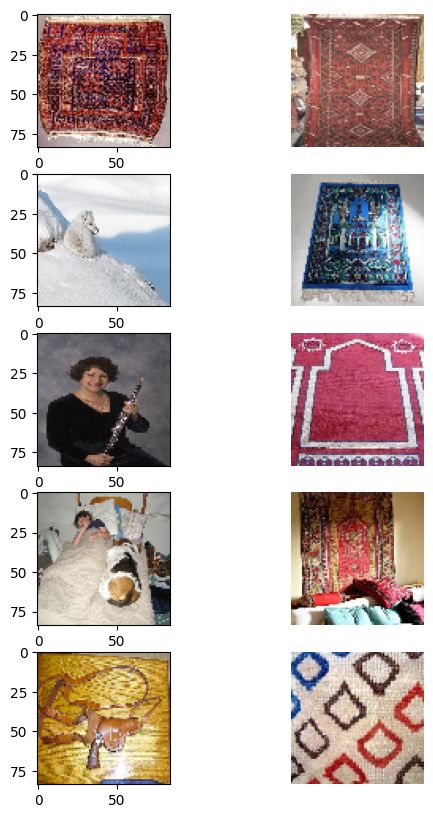

In [ ]:
#idxx=random.sample(list(y_test), 5)
randLayer=np.random.normal(0.1, 0.05,size=(84,84,3))
import cv2

def flip (img):
  img=np.reshape(img, (84,84,3))
  img2= cv2.flip(img, 1)
  return img2 #np.expand_dims(img2, axis=-1)

class Data_GeneratorGeneral(tf.keras.utils.Sequence):

    #def __init__(self, datatype='train', dim=(32,32), n_channels=1, way=20, shot=1, query=1, num_batch=10):
    def __init__(self, datatype='train', dim=(84,84,3), num_per_class=1, n_channels=1, way=20,vway=20, query=1, shot=1, num_batch=10):
        'Initialization'
        global k,idxx
        self.data=x_train
        self.y=y_train

        if(datatype=='val'):
          self.data=x_val
          self.y=y_val

        if(datatype=='test'):
          self.data=x_test
          self.y=y_test

        self.dim = dim
        self.n_channels = n_channels
        #print(num_per_class)
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.way = way
        self.vway = vway
        self.shot = shot
        self.query = query
        self.idx2=np.arange(self.way)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'

        X_sample, X_query, label= self.__data_generation()
        return [X_sample, X_query], label

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        n_classes=np.unique(self.y)
        X_sample = []; #np.empty((way, shot, *dim))
        X_query = [] #np.empty((way, query, *dim))
        label = np.zeros((self.way*self.query,self.way))*0.1 # size 25 * 5
        noise=[]; #label1 = np.ones((self.way*self.query,self.way*self.shot))*0.2
        layr1 = random.sample([0,1,2], 1)[0]
        idx=random.sample(list(self.y), self.way)

        for i in range(self.way):
            X_temp = [];
            sample_idx1 = random.sample(self.y[idx[i]], self.shot)
            for s in range(self.shot):
              img=self.data[sample_idx1[s]]
              X_temp+= [img]
            X_sample.append(X_temp)

            sample_idx2 = random.sample(self.y[idx[i]][0:300], self.query)
            for q in range(self.query):
                img1=self.data[sample_idx2[q]]
                #img1[:,:,layr1] = img1[:,:,layr1] + randLayer[:,:,layr1]
                X_tempp=[]
                X_tempp += [img1]
                # #img2= generator1(np.reshape(flip(img)*(1-mask)+ Noise*mask, (1,84,84,3)))[0].numpy()
                X_tempp += [flip(img1)]
                X_query.append(X_tempp)
                #X_query.append([self.data[matchInd[sample_idx1[s]]]])
                label[i*self.query+q,i]= 1

        return np.array(X_sample), np.array(X_query),label #np.concatenate((label,label),axis=0)

train_way = 5
val_way = 5
shot = 5
query = 5
n=600
#idx = random.sample(list(y_test), train_way)
val_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=2)
# print(val_loader[1])
(x,y),z = val_loader[0]
print(x.shape,y.shape,z.shape,z)
# print(z)
(img1,img2),z=val_loader[1]
fig = plt.figure(figsize=(6, 10))

for j in range(5):
    plt.subplot(5,2,2*j+1)
    plt.imshow(img1[j,0,:, :,:] )
    plt.subplot(5,2,2*j+2)
    plt.imshow(img2[j,0,:, :,:] )
    plt.axis('off')
plt.show()
#[4 1 3 2 0]

# traning

In [ ]:

train_way = 5
shot = 5
query=shot
val_way=train_way
n=600
lr=0.00001
dim=(84,84,3)

#import tensorflow_probability as tfp
from tensorflow.keras import callbacks as cb
import tensorflow as tf
cross = tf.keras.losses.CategoricalCrossentropy()

def scheduler(epoch):
    global lr
    if epoch %5== 0:
        lr/= 1.2
    return lr

if __name__ == "__main__":
    #conv = convNet(dim)
    #conv= load_model('Model/test_new_h5_file.h5')
    conv= load_model('Model/without_proto_conv_backbone_miniImagemet_5_5_1000_5.h5')
    conv_5d = TimeDistributed(conv)
    input_shape = (None,84,84,3)

    #support
    sample = Input(input_shape)
    out_feature = conv_5d(sample)

    out_feature1 = Lambda(reduce_tensor, name="out_feature1")(out_feature)

    #fs =  self_attention(out_feature1,out_feature1)
    #.........................................................
    #query
    inp = Input(input_shape)
    map_feature = conv_5d(inp)
    map_feature1 = Lambda(reduce_tensor , name="map_feature1")(map_feature)

    #fq = self_attention(map_feature1,out_feature1)
    d1 = Lambda(proto_dist)([out_feature1, map_feature1])
    #d20
    A_reduced=tf.constant(A_reduced)
    SA = tf.matmul(out_feature1, A_reduced)
    softmax_SA = tf.nn.softmax(SA, axis=1)
    d20 = tf.matmul(softmax_SA, A_reduced, transpose_b=True)
    # #d2
    d2 = Lambda(proto_dist)([d20,map_feature1])
    pred=(d1+d2)/2

    #.........................................................

    combine1 = Model([sample,inp], [pred])
    optimizer = Adam(0.001)   #'categorical_crossentropy' contrastive_loss,

    combine1.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(combine1.summary())
 #.........................................................................................
    train_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=1000)
    val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,patience = 15, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience=10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #Data_GeneratorRaviStratify

    history4 = combine1.fit(train_loader,epochs = 20,steps_per_epoch = 100,validation_data = val_loader, use_multiprocessing=True, workers=8, shuffle=False, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])

combine1.save('Model/test_new_h5_file.h5')    #way-shot-qyery

#combine1.save('Model/proto_conv4_miniImagemet_5_5_1000.h5')

#np.save('Model/test_new_npy_file.npy', history4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 84, 84, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, None, 1600)           113600    ['input_1[0][0]',             
 ributed)                                                            'input_2[0][0]']             
                                                                                                  
 out_feature1 (Lambda)       (None, 1600)                 0         ['time_distributed[0][0]']    
                                                                                                  
 input_2 (InputLayer)        [(None, None, 84, 84, 3)]    0         []                        

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


100/100 [==============================] - 26s 167ms/step - loss: 0.8391 - accuracy: 0.8140 - val_loss: 1.0211 - val_accuracy: 0.6916 - lr: 8.3333e-06
Epoch 2/20
100/100 [==============================] - 16s 148ms/step - loss: 0.8586 - accuracy: 0.7992 - val_loss: 1.0123 - val_accuracy: 0.6936 - lr: 8.3333e-06
Epoch 3/20
100/100 [==============================] - 16s 152ms/step - loss: 0.8601 - accuracy: 0.7948 - val_loss: 1.0487 - val_accuracy: 0.6656 - lr: 8.3333e-06
Epoch 4/20
100/100 [==============================] - 15s 148ms/step - loss: 0.8274 - accuracy: 0.8180 - val_loss: 1.0295 - val_accuracy: 0.6772 - lr: 8.3333e-06
Epoch 5/20
100/100 [==============================] - 15s 142ms/step - loss: 0.8389 - accuracy: 0.8096 - val_loss: 1.0154 - val_accuracy: 0.6972 - lr: 8.3333e-06
Epoch 6/20
100/100 [==============================] - 15s 142ms/step - loss: 0.8648 - accuracy: 0.7904 - val_loss: 1.0035 - val_accuracy: 0.7084 - lr: 6.9444e-06
Epoch 7/20
100/100 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# fine tuning

In [ ]:

train_way = 5
shot = 5
query=shot
val_way=train_way
n=600
lr=0.0001
dim=(84,84,3)

#import tensorflow_probability as tfp
from tensorflow.keras import callbacks as cb
import tensorflow as tf
cross = tf.keras.losses.CategoricalCrossentropy()

def scheduler(epoch):
    global lr
    if epoch %2== 0:
        lr/= 1.2
    return lr

if __name__ == "__main__":

    # combine3= load_model('Model/test_new_h5_file.h5')    #way-shot-qyery
    # combine3= load_model('Model/proto_conv4_miniImagemet_5_5_1000.h5')
 #.........................................................................................
    train_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=1000)
    val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,patience = 15, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience=10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #Data_GeneratorRaviStratify

    history4 = combine3.fit(train_loader,epochs = 10,steps_per_epoch = 100,validation_data = val_loader, use_multiprocessing=True, workers=8, shuffle=False, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])




Epoch 1/10
100/100 [==============================] - 23s 185ms/step - loss: 0.9860 - accuracy: 0.7120 - val_loss: 0.8728 - val_accuracy: 0.7804 - lr: 8.3333e-05
Epoch 2/10
100/100 [==============================] - 18s 164ms/step - loss: 0.9863 - accuracy: 0.7056 - val_loss: 0.8914 - val_accuracy: 0.7736 - lr: 8.3333e-05
Epoch 3/10
100/100 [==============================] - 18s 170ms/step - loss: 0.9853 - accuracy: 0.7008 - val_loss: 0.8848 - val_accuracy: 0.7752 - lr: 6.9444e-05
Epoch 4/10
100/100 [==============================] - 16s 154ms/step - loss: 0.9678 - accuracy: 0.7196 - val_loss: 0.8797 - val_accuracy: 0.7736 - lr: 6.9444e-05
Epoch 5/10
100/100 [==============================] - 15s 143ms/step - loss: 0.9808 - accuracy: 0.7112 - val_loss: 0.9017 - val_accuracy: 0.7592 - lr: 5.7870e-05
Epoch 6/10
100/100 [==============================] - 17s 156ms/step - loss: 0.9519 - accuracy: 0.7328 - val_loss: 0.8913 - val_accuracy: 0.7676 - lr: 5.7870e-05
Epoch 7/10
100/100 [========

In [ ]:
combine1.save('Model/test_new_h5_file.h5')    #way-shot-qyer
np.save('Model/test_new_npy_file.npy', history4)

NameError: name 'combine1' is not defined

In [ ]:
cd ..

/content/gdrive/.shortcut-targets-by-id/1woqUjZb-LgCmTUa1lsYDtuculTStAOi4/MINI PROJECT


# testing

In [ ]:
model= combine3 #
# model= load_model('Model/test_new_h5_file.h5')
# model= load_model('Model/proto_conv4_miniImagemet_5_5_1000.h5')
train_way = 5
shot = 5
query=shot
val_way=train_way
n=600

val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=100)
model.evaluate(val_loader)

100/100 [==============================] - 2s 16ms/step - loss: 0.9670 - accuracy: 0.7148


[0.9670047760009766, 0.7148000001907349]

In [ ]:
cd MyDrive

/content/gdrive/MyDrive


In [ ]:
!ls


 1695748908939.jpg					   'Investigationg spam email.pdf'
'Colab Notebooks'					   'My documents '
'FullbridgeX Career Development 5x Certificate _ edX.pdf'   Project.gdoc
'Hyma certificates'					   'Remaining all pdfs'
 Hymasri						    RGUKT
 images_array.pkl					   'Sharing contact via Truecaller'


In [ ]:
from google.colab import files

# Download the file
files.download('test_new_h5_file.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Download the file
files.download('test_new_npy_file.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>